In [1]:
print('hello world')

hello world


In [2]:
words = open('../names.txt', 'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
uniq=list(set(c for w in words for c in w))
uniq= uniq + ['.']
vocab=sorted(uniq)
stoi = {c:i for i,c in enumerate(vocab) }
itos = {i:s for s,i in stoi.items()}

In [5]:
vocab_len=len(vocab)
vocab_len

27

In [6]:
block_size=3
X,Y=[],[]
for w in words[:5]:
  context = [0]*block_size
  for ch in w+'.':
    X.append(context)
    Y.append(stoi[ch])
    print(f'{"".join(itos[c] for c in context)} --> {ch}')
    context = context[1:] + [stoi[ch]]

X=torch.tensor(X)
Y=torch.tensor(Y)

... --> e
..e --> m
.em --> m
emm --> a
mma --> .
... --> o
..o --> l
.ol --> i
oli --> v
liv --> i
ivi --> a
via --> .
... --> a
..a --> v
.av --> a
ava --> .
... --> i
..i --> s
.is --> a
isa --> b
sab --> e
abe --> l
bel --> l
ell --> a
lla --> .
... --> s
..s --> o
.so --> p
sop --> h
oph --> i
phi --> a
hia --> .


In [7]:
X.shape,Y.shape


(torch.Size([32, 3]), torch.Size([32]))

In [8]:
n_emb=2
C=torch.randn((vocab_len, 2))
C.shape

torch.Size([27, 2])

In [9]:
emb=C[X]
print(emb.shape)

emb[3], X[3], C[[5,13,13]]

torch.Size([32, 3, 2])


(tensor([[-0.2908, -0.3929],
         [-0.8274,  0.2596],
         [-0.8274,  0.2596]]),
 tensor([ 5, 13, 13]),
 tensor([[-0.2908, -0.3929],
         [-0.8274,  0.2596],
         [-0.8274,  0.2596]]))

In [10]:
n_neurons=100
W1 = torch.randn((block_size*n_emb, n_neurons))
b1 = torch.randn(n_neurons)
W1.shape, b1.shape



(torch.Size([6, 100]), torch.Size([100]))

In [11]:
W2 = torch.randn((n_neurons, vocab_len))
b2 = torch.randn(vocab_len)
W2.shape, b2.shape

(torch.Size([100, 27]), torch.Size([27]))

In [12]:
hpreact = emb.view(-1, block_size*n_emb) @ W1 + b1
h = torch.tanh(hpreact)
logits = h @ W2 + b2
probs =  F.softmax(logits, 1)

In [13]:
loss = F.cross_entropy(logits, Y)
loss

tensor(17.5956)

In [98]:
# train prep
n_emb=10
n_neurons=100 # n_hidden
block_size=6

X,Y=[],[]
for w in words:
  context = [0]*block_size
  for ch in w+'.':
    X.append(context)
    Y.append(stoi[ch])
    #print(f'{"".join(itos[c] for c in context)} --> {ch}')
    context = context[1:] + [stoi[ch]]

X=torch.tensor(X)
Y=torch.tensor(Y)

g = torch.Generator().manual_seed(782361)

# init
C  = torch.randn((vocab_len, n_emb),            generator=g)
W1 = torch.randn((block_size*n_emb, n_neurons), generator=g) * ((5/3)/((block_size*n_emb)**0.5))
# due to batchnorm formula, b1 no longer does any effect
#b1 = torch.randn(n_neurons,                     generator=g) * 0.001
W2 = torch.randn((n_neurons, vocab_len),        generator=g) * 0.01
b2 = torch.randn(vocab_len,                     generator=g) * 0.001
bngain = torch.ones((1,n_neurons))
bnbias = torch.zeros((1,n_neurons))

# check why mean are zeros and std are ones
bnmean_running = torch.zeros((1, n_neurons))
bnstd_running = torch.ones((1, n_neurons))

#parameters = [C,W1,b1,W2,b2, bngain, bnbias]
parameters = [C,W1,W2,b2, bngain, bnbias]
for p in parameters:
  p.requires_grad = True

In [99]:
((5/3)/((block_size*n_emb)**0.5))

0.21516574145596762

In [100]:
X.shape, Y.shape

(torch.Size([228146, 6]), torch.Size([228146]))

In [101]:
lossi = []

In [102]:
# train
lr = 0.1

for _ in range(10_000):
  # minibatch
  batch = torch.randint(0, X.shape[0], (64,), generator=g)

  # forward pass
  emb=C[X[batch]]
  hpreact = emb.view(-1, block_size*n_emb) @ W1 # + b1
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  # notes: read again, check what happens to the result of hpreact after below operation
  hpreact = bngain * ((hpreact - bnmeani) / bnstdi) + bnbias
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Y[batch])
  
  # clear grads
  for p in parameters:
    p.grad = None
  # recompute grads
  loss.backward()
  # update
  for p in parameters:
    p.data += -lr * p.grad

  lossi.append(loss.item())
loss

tensor(2.2005, grad_fn=<NllLossBackward0>)

In [103]:
hpreact.shape

torch.Size([64, 100])

In [104]:
hpreact.mean(0).shape

torch.Size([100])

(array([327., 203., 158., 178., 143., 114., 162., 138., 117., 115., 126.,
        160., 134., 119.,  92.,  84., 132.,  78.,  94., 103.,  68., 100.,
        109.,  92.,  55.,  96.,  64.,  89.,  96.,  83.,  61.,  85.,  90.,
         92.,  95., 107.,  98., 138., 108., 129., 125., 149., 126., 112.,
        195., 153., 159., 214., 227., 308.]),
 array([-9.99494433e-01, -9.59505864e-01, -9.19517295e-01, -8.79528726e-01,
        -8.39540157e-01, -7.99551588e-01, -7.59563019e-01, -7.19574450e-01,
        -6.79585881e-01, -6.39597312e-01, -5.99608743e-01, -5.59620174e-01,
        -5.19631605e-01, -4.79643036e-01, -4.39654467e-01, -3.99665898e-01,
        -3.59677329e-01, -3.19688760e-01, -2.79700191e-01, -2.39711622e-01,
        -1.99723053e-01, -1.59734484e-01, -1.19745915e-01, -7.97573459e-02,
        -3.97687769e-02,  2.19792128e-04,  4.02083611e-02,  8.01969302e-02,
         1.20185499e-01,  1.60174068e-01,  2.00162637e-01,  2.40151206e-01,
         2.80139775e-01,  3.20128344e-01,  3.60116

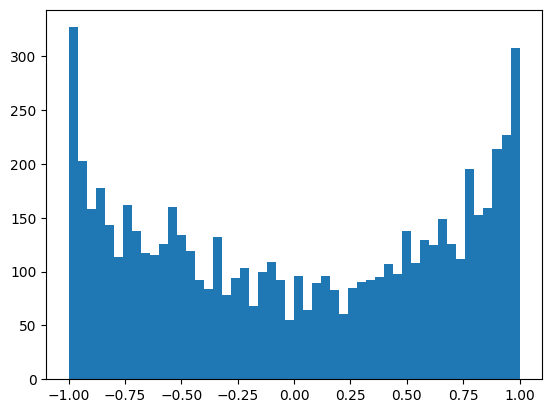

In [105]:
plt.hist(h.view(-1).tolist(), 50)

(array([  2.,   3.,   3.,   8.,  11.,  18.,  24.,  30.,  34.,  51.,  64.,
         85., 115., 124., 146., 215., 217., 328., 376., 435., 403., 438.,
        350., 371., 377., 409., 336., 304., 249., 184., 180., 125., 103.,
         59.,  54.,  44.,  36.,  30.,  15.,  10.,  14.,   4.,   8.,   4.,
          2.,   0.,   1.,   0.,   0.,   1.]),
 array([-4.14135456, -3.95533377, -3.76931297, -3.58329218, -3.39727139,
        -3.21125059, -3.0252298 , -2.839209  , -2.65318821, -2.46716742,
        -2.28114662, -2.09512583, -1.90910503, -1.72308424, -1.53706345,
        -1.35104265, -1.16502186, -0.97900106, -0.79298027, -0.60695948,
        -0.42093868, -0.23491789, -0.04889709,  0.1371237 ,  0.32314449,
         0.50916529,  0.69518608,  0.88120687,  1.06722767,  1.25324846,
         1.43926926,  1.62529005,  1.81131084,  1.99733164,  2.18335243,
         2.36937323,  2.55539402,  2.74141481,  2.92743561,  3.1134564 ,
         3.2994772 ,  3.48549799,  3.67151878,  3.85753958,  4.04356037,
 

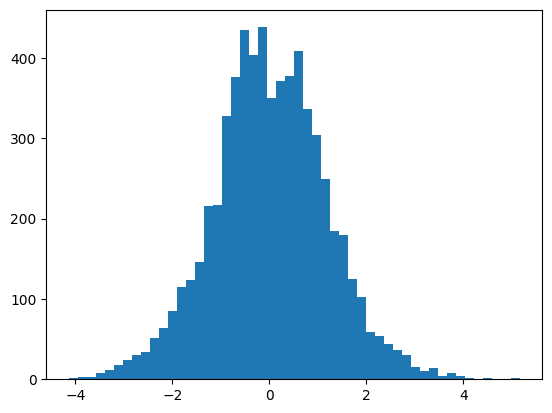

In [106]:
plt.hist(hpreact.view(-1).tolist(), 50)

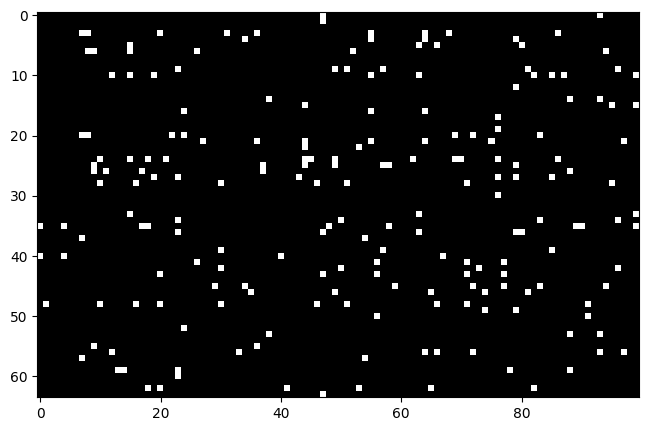

In [107]:
plt.figure(figsize=(10,5))
plt.imshow(h.abs() > 0.99, cmap='gray')

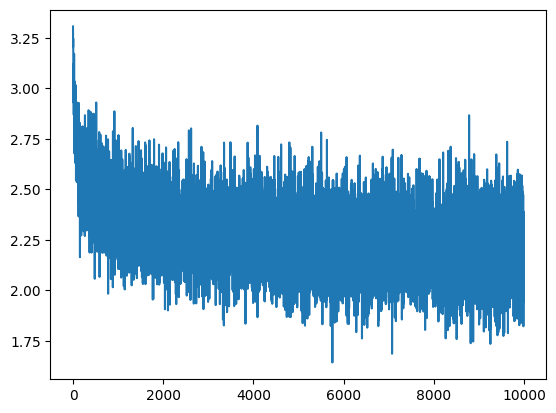

In [108]:
plt.plot(lossi)

In [109]:
# init estimate loss
-torch.tensor(1/vocab_len).log()

tensor(3.2958)

(array([  27.,  157.,  534., 1571., 1939., 1482.,  521.,  135.,   32.,
           2.]),
 array([-4.14135456, -3.21125059, -2.28114662, -1.35104265, -0.42093868,
         0.50916529,  1.43926926,  2.36937323,  3.2994772 ,  4.22958117,
         5.15968513]),
 <BarContainer object of 10 artists>)

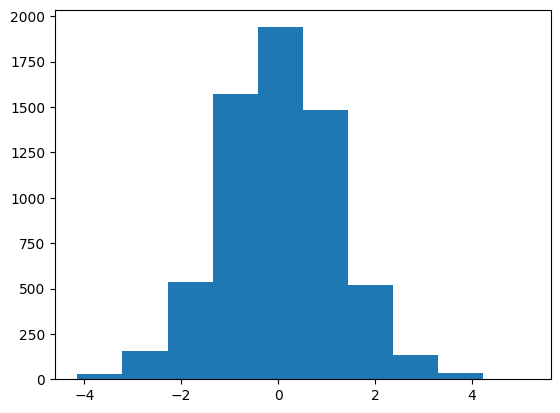

In [110]:
plt.hist(hpreact.view(-1).tolist())


(array([ 57., 226., 356., 412., 382., 161.,  84.,  35.,  12.,   3.]),
 array([-3.962466  , -2.86457798, -1.76668997, -0.66880195,  0.42908607,
         1.52697408,  2.6248621 ,  3.72275012,  4.82063813,  5.91852615,
         7.01641417]),
 <BarContainer object of 10 artists>)

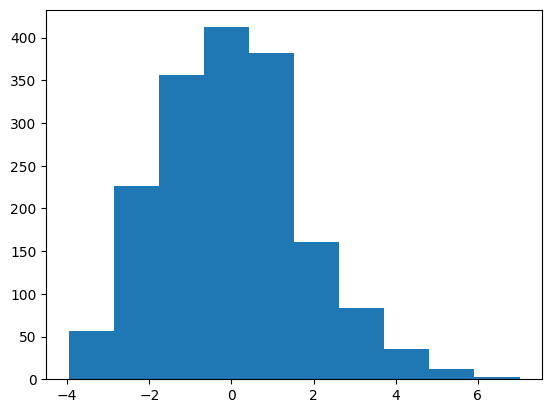

In [111]:
plt.hist(logits.view(-1).tolist())

In [112]:
# inference
out=[]
for i in range(10):
  out.append([])
  context = [0] * block_size
  while True:
    # forward pass
    emb = C[context]
    hpreact = emb.view(-1, block_size*n_emb) @ W1 # + b1
    hpreact = ((hpreact - bnmean_running) / bnstd_running)
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    probs = F.softmax(logits, 1)
    hit = torch.multinomial(probs, num_samples=1, replacement=True).item()
    out[i].append(hit)
    if hit == 0:
      break
    context = context[1:] + [hit]
for o in out:
  print(''.join(itos[x] for x in o))

broetta.
carley.
naxitk.
shony.
hilhinn.
kmoyne.
brendey.
jasler.
hafzane.
eldighty.
